In [68]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, GridSearchCV
from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

import sys
sys.path.append('../')

from src.bet_sizing import SimultaneousKelly

In [69]:
train_df = pd.read_csv("../data/processed/train.csv").drop(columns=["BOUT_ID", "EVENT_ID", "DATE", "BOUT_ORDINAL"])
test_df = pd.read_csv("../data/processed/test.csv").drop(columns=["BOUT_ID", "EVENT_ID", "DATE", "BOUT_ORDINAL"])

In [70]:
X_train = train_df.drop(columns=["RED_WIN"])
y_train = train_df["RED_WIN"]
X_test = test_df.drop(columns=["RED_WIN"])
y_test = test_df["RED_WIN"]

# cv = TimeSeriesSplit(n_splits=5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

pipe = Pipeline([
    ("scale", StandardScaler()),
    ("classify", LogisticRegression(max_iter=300, random_state=0))
])

param_grid = {
    "classify__C": np.logspace(-4, 4, 10),
}

grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring="neg_log_loss", n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('classify',
                                        LogisticRegression(max_iter=300,
                                                           random_state=0))]),
             n_jobs=-1,
             param_grid={'classify__C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])},
             scoring='neg_log_loss', verbose=2)

In [71]:
y_pred_train_prob = grid_search.predict_proba(X_train)[:, 1]
log_loss(y_train, y_pred_train_prob), roc_auc_score(y_train, y_pred_train_prob)

(0.6313496484587275, 0.6827465422414967)

In [72]:
probs = grid_search.predict_proba(X_test)
red_probs, blue_probs = probs[:, 1], probs[:, 0]

In [73]:
odds = pd.read_csv("../data/processed/backtest_odds.csv")
odds["RED_MODEL_PROBS"] = red_probs
odds["BLUE_MODEL_PROBS"] = blue_probs
odds

,BOUT_ID,EVENT_ID,DATE,BOUT_ORDINAL,RED_FIGHTER_ODDS,BLUE_FIGHTER_ODDS,RED_WIN,RED_MODEL_PROBS,BLUE_MODEL_PROBS
0,3a8c0158d910546d,f5585e675af7afd4,2022-01-15,0,1.469937,2.743333,1.0,0.519496,0.480504
1,7c2a02b5ea169b54,f5585e675af7afd4,2022-01-15,1,1.261991,3.975000,1.0,0.565786,0.434214
2,3738135e4c9d8273,f5585e675af7afd4,2022-01-15,2,2.028730,1.796695,1.0,0.637628,0.362372
3,f9a4e625dffc30d4,f5585e675af7afd4,2022-01-15,6,1.462680,2.793333,1.0,0.702036,0.297964
4,8d89f3b8798f444d,f5585e675af7afd4,2022-01-15,7,1.629805,2.316667,1.0,0.532177,0.467823
...,...,...,...,...,...,...,...,...,...
910,2f414494f2b6f426,c398235fcaf8d71d,2024-03-16,8,2.920000,1.414494,0.0,0.498189,0.501811
911,acc7392d48cc09a0,c398235fcaf8d71d,2024-03-16,9,2.671429,1.480447,1.0,0.619567,0.380433
912,35f9beb94b4ef9e2,c398235fcaf8d71d,2024-03-16,10,5.448571,1.153292,1.0,0.277998,0.722002
913,a7fd9da657bbce8e,c398235fcaf8d71d,2024-03-16,11,1.466121,2.741429,NaN,0.691180,0.308820


In [74]:
event_ids = odds["EVENT_ID"].unique()   # preserves order of appearance
event_ids

array(['f5585e675af7afd4', '335ad945324c3a2e', '883922e5cd6d8473',
       'cbb682f5fcc44bfc', '77940e45bc86208e', 'f6a7b02c42e9fc5b',
       '75e0d3cc2262b732', '1f9344211ca7fd60', '1d00756835ca67c9',
       '1fac46d466abd5b8', '3a97fda0de6f1fa4', '8753e125f4499816',
       '236a37d96d476164', '6bf5a7d3e081ade2', '253d3f9e97ca149a',
       '60ba33c3f555a7a3', 'a6c32678efd4f434', '57591bbf1623574e',
       '3a24769a4855040a', 'a0a680fe2f6cc8e6', 'eb42d4febfafefd1',
       '4a9e305633f3ef47', '31da66df48c0c1a0', '8fd76e1b49c00ae2',
       '319c15b8aac5bfde', 'b0a6124751a56bc4', '8f6a18831a120817',
       'a23e63184c65f5b8', '4f853e98886283cf', '00a905a4a4a2b071',
       '93bf96be327fcd98', '8d477c3fbe001f9d', '4f670b7972fa0a2e',
       '49c29e57d4e2be6f', '885e7f70dcac0007', 'be5aab761c40ef35',
       '756f45905fb20cb5', 'b3b6e80b7d5f8f0d', '012fc7cd0779c09a',
       'b23388ff8ac6637b', 'f65a0eb902f9476b', '56ec58954158966a',
       '2e2cdb6e9eb84bb9', '5717efc6f271cd52', 'd26394fc0e8e88

In [75]:
def calculate_profit(wager_side, red_win, wager, odds):
    if np.isnan(red_win) or wager == 0:
        return 0
    
    if wager_side == "RED":
        return wager * red_win * odds - wager
    else:
        return wager * (1 - red_win) * odds - wager

In [76]:
bankroll = 100.0
total_investment = 0.0

dates = [pd.to_datetime("2022-01-01")]
bankrolls = [100.0]

for i, event_id in enumerate(event_ids):
    sliced = odds[odds["EVENT_ID"] == event_id].copy()
    kelly = SimultaneousKelly(
        red_probs=sliced["RED_MODEL_PROBS"].to_numpy(),
        blue_probs=sliced["BLUE_MODEL_PROBS"].to_numpy(),
        red_odds=sliced["RED_FIGHTER_ODDS"].to_numpy(),
        blue_odds=sliced["BLUE_FIGHTER_ODDS"].to_numpy(),
        current_bankroll=bankroll,
    )

    red_wagers, blue_wagers = kelly()
    sliced["RED_WAGER"] = red_wagers
    sliced["BLUE_WAGER"] = blue_wagers

    total_investment += sliced["RED_WAGER"].sum() + sliced["BLUE_WAGER"].sum()
    total_investment = round(total_investment, 2)

    sliced["RED_PROFIT"] = sliced.apply(lambda row: calculate_profit("RED", row["RED_WIN"], row["RED_WAGER"], row["RED_FIGHTER_ODDS"]), axis=1).round(2)
    sliced["BLUE_PROFIT"] = sliced.apply(lambda row: calculate_profit("BLUE", row["RED_WIN"], row["BLUE_WAGER"], row["BLUE_FIGHTER_ODDS"]), axis=1).round(2)

    bankroll += sliced["RED_PROFIT"].sum() + sliced["BLUE_PROFIT"].sum()
    bankroll = round(bankroll, 2)

    dates.append(pd.to_datetime(sliced["DATE"].iloc[0]))
    bankrolls.append(bankroll)

    print(f"Event {i + 1}/{len(event_ids)}: Bankroll = {bankroll}")

total_profit = bankroll - 100.0
print(f"ROI: {total_profit / total_investment}")

Event 1/94: Bankroll = 100.12
Event 2/94: Bankroll = 98.2
Event 3/94: Bankroll = 93.98
Event 4/94: Bankroll = 87.59
Event 5/94: Bankroll = 88.09
Event 6/94: Bankroll = 84.98
Event 7/94: Bankroll = 84.5
Event 8/94: Bankroll = 78.56
Event 9/94: Bankroll = 78.93
Event 10/94: Bankroll = 86.14
Event 11/94: Bankroll = 90.51
Event 12/94: Bankroll = 86.74
Event 13/94: Bankroll = 84.62
Event 14/94: Bankroll = 91.32
Event 15/94: Bankroll = 92.3
Event 16/94: Bankroll = 95.8
Event 17/94: Bankroll = 96.59
Event 18/94: Bankroll = 94.46
Event 19/94: Bankroll = 88.16
Event 20/94: Bankroll = 94.73
Event 21/94: Bankroll = 96.35
Event 22/94: Bankroll = 90.06
Event 23/94: Bankroll = 90.46
Event 24/94: Bankroll = 94.26
Event 25/94: Bankroll = 97.88
Event 26/94: Bankroll = 100.63
Event 27/94: Bankroll = 94.78
Event 28/94: Bankroll = 104.51
Event 29/94: Bankroll = 102.73
Event 30/94: Bankroll = 99.34
Event 31/94: Bankroll = 102.25
Event 32/94: Bankroll = 99.09
Event 33/94: Bankroll = 102.87
Event 34/94: Bank

In [77]:
import matplotlib.pyplot as plt

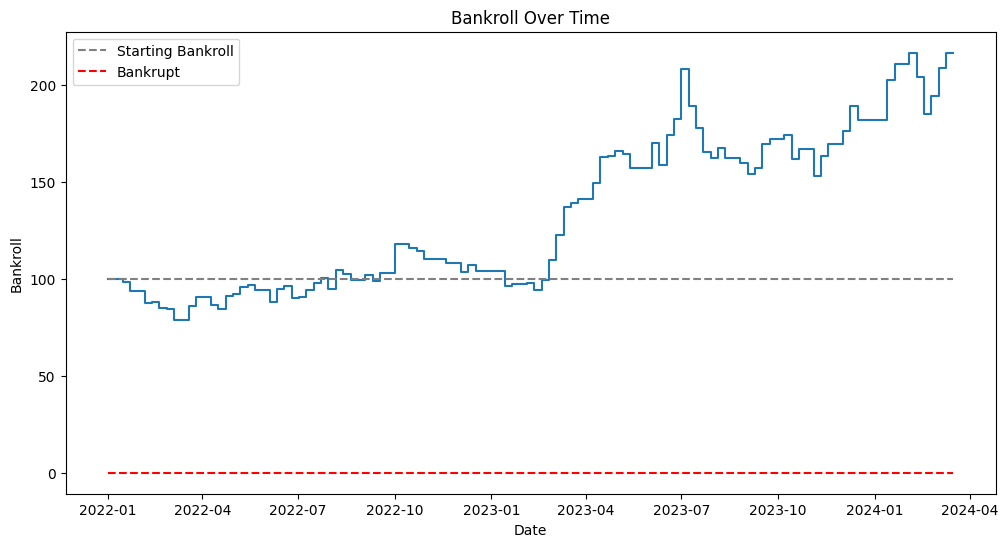

In [78]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.step(dates, bankrolls)
ax.hlines(100, dates[0], dates[-1], color="grey", linestyle="--", label="Starting Bankroll")
ax.hlines(0, dates[0], dates[-1], color="red", linestyle="--", label="Bankrupt")
ax.set_title("Bankroll Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Bankroll")
ax.legend()
plt.show()